In [146]:
## prepare data

In [1]:
import pandas as pd; import numpy as np 
import os
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import warnings
from functools import reduce
import importlib
from tools import write_file
import multiprocessing
import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/Users/jerryliu/jerry_jupyter/internship/tools.py'>

In [2]:
#load four mutation files.
path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/mutation_files/'
file_list = ['damaging','hotspot','nonconserving','otherconserving']
drug_path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/primary-screen-replicate-collapsed-logfold-change.csv'
out_path = '/Users/jerryliu/jerry_jupyter/internship/output/'

In [3]:
#read drug sensitivity files. 
def read_drug(drug_path):
    drug_data = pd.read_csv(drug_path)
    drug_data = drug_data.set_index(drug_data.columns[0])
    return(drug_data)

In [4]:
#funtion to merge two mutation files.
def merge_mt(m_f1, m_f2, drug_id, gene_filter = False):
    # input: dataframe with index as cell line id. 
    # output: merged dataframe
    #cell lines: m_f1 & m_f2;  cancer genes: m_f1 | m_f2.
    if not gene_filter:
        cl_id = set.intersection(set(m_f1.index), set(m_f2.index), set(drug_id))
    else:
        cl_id = set.intersection(set(m_f1.index), set(m_f2.index))
        
    gene_id = set.union(set(m_f1.columns), set(m_f2.columns))

    m_f1 = m_f1.reindex(cl_id, columns = gene_id, fill_value = 0 )
    m_f2 = m_f2.reindex(cl_id, columns = gene_id, fill_value = 0)
    #combine the two files.
    m_comb = pd.DataFrame(np.where(m_f1 == 0, m_f2, m_f1), index = cl_id, columns=gene_id)
    
    return(m_comb)

In [5]:
def filter_genes(file, thresh = 0.1):
    """
    thresh: at least ## of cell lines are mutated and are kept. 
    input: list of dataframes of mutated genes.
    output: list of most mutated genes. 
    """
    gene_bool = file.apply(lambda x: True if (x == 1).sum()/len(x) >= thresh else False).values
    return(file.columns[gene_bool])
    

In [31]:

def EN_cv_in(x_train, y_train, fold, alpha, l1_ratio):
        """
        input: training set. (each alpha, l1_ratio parameter)
        output: averge spearman correlation score of 10 results
        """
        #alpha = p1, l1_ratio = p2
        kf_in = KFold(n_splits = fold)
        cv_perf = np.array([]) 
        for train_in, test_in in kf_in.split(x_train):

            x_train_in, x_test_in, y_train_in, y_test_in = x_train[train_in], x_train[test_in], y_train[train_in], y_train[test_in]

            #build model with each combination of parameters. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                regr = ElasticNet(random_state = 0, alpha= alpha, l1_ratio=l1_ratio, fit_intercept = False)
                regr.fit(x_train_in, y_train_in)
                
            y_pre = regr.predict(x_test_in)
            #perforamance matrix of the model is the Pearson's corrlation coeeficient r. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                r = np.abs(pd.Series(y_pre).corr(pd.Series(y_test_in), method = 'spearman'))
                cv_perf = np.append(cv_perf,[r])
                del regr
        return(np.mean(cv_perf))

    
def out_loop (x, y_total, cl_id, out_cv_fold= 5):
    ''' 5 fold cv (outter-loop)
    # x: (#_(80%)C, #_genes); y: (#_(80%)C,)
    '''
    kf = KFold(n_splits = out_cv_fold)
    pre_y_array = dict(list(zip(cl_id,[ [] for _ in range(len(cl_id))])))

    for train, test in kf.split(x):
        x_train, x_test, y_train, y_test = x.values[train], x.values[test], y_total.values[train], y_total.values[test]
        train_label, test_label = x.index[train], x.index[test]
        # 10-fold in x_train (inner-loop). 
        # each pair of alpha and l1_ratio, do cross training to sellect best pair. 

        l1_ratio_list = np.linspace(start = 0.2, stop = 1.0, num = 10) #10 values
        alpha_list =  np.array([math.exp(i) for i in np.arange(-15.999,5,1.7)]) # 250 values
        #alpha_list =  np.array([math.exp(i) for i in np.arange(-8,5,0.8)]) #  values
        para_matrix = {(l1_ratio, alpha):0 for l1_ratio in l1_ratio_list for alpha in alpha_list}

        for (l1_ratio, alpha) in para_matrix:
            #do ten fold cv to sellect best parameter pairs. 
            ave_per = EN_cv_in(x_train= x_train, y_train = y_train, fold = 10, alpha = alpha, l1_ratio= l1_ratio)
            para_matrix[(l1_ratio, alpha)] = ave_per
        print(para_matrix)
        
        #return the best alpha-l1-ratio pair.
        op_l1_ratio, op_alpha = pd.Series(para_matrix).idxmax() 
        print('the best validation performance is: ', para_matrix[(op_l1_ratio, op_alpha)])
        
        #predict on the 5th-fold set (testing set)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            regr = ElasticNet(random_state=0, alpha= op_alpha, l1_ratio = l1_ratio, fit_intercept = False)
            regr.fit(x_train, y_train)
            y_pre = regr.predict(x_test)
            
        del regr
        #add results to the storage dictionary. 
        for index, value in zip(test_label, y_pre): pre_y_array[index].append(value)
        print('performance on the test set is:', pd.Series(y_pre).corr(pd.Series(y_test),method = 'spearman') )
        #break
    #add the prediction to the list.
    pre_y_array = pd.Series(pre_y_array).reindex(cl_id)

    return(pre_y_array)

def drug_model(comp_index, m_file,  drug_data, out_path):
    """
    input: m_file mutation matrix with unpreprocessed binery values.
    output: mean prediction values of 10 iterations in pd.Sereis type.
    """
    #eliminate cell lines with nan dryg sensitivity data.
    #comp_index = 0
#     print(comp_index)
#     print(m_file.shape)
    
    valid_cl_index = drug_data.loc[m_file.index,:].iloc[:,comp_index].dropna().index
    Y = drug_data.iloc[:, comp_index][valid_cl_index]
    drug_name = drug_data.columns[comp_index]
    print('drug_name is: ',drug_name)
    print('number of missing values in Y: ', Y.isnull().sum())
    m_file_notna = m_file.loc[valid_cl_index,:]
    
    #normalize the each col to have ~0 mean and ~1 sd. 
    norm_m_file = (m_file_notna - m_file_notna.mean(axis = 0)) / m_file_notna.std(axis = 0)
    print(norm_m_file.sum())
    
    print('### normalize with mean=0, std = 1.')
    norm_m_file.dropna(axis = 1, inplace = True)
    
#     #Use features that have pearson correlation with Y over 0.1.
#     cor_number = norm_m_file.corrwith(Y, axis = 0, method = 'pearson')
#     #number of genes that have correlation over 0.1
#     #sum(np.abs(cor_number) >= 0.1)
#     norm_m_file = norm_m_file.loc[:, np.abs(cor_number) >= 0.1]
#     #print('number of features selected {}'.format(sum(np.abs(cor_number) >= 0.1)))
    
    
    print('number of features selected {}'.format(norm_m_file.shape[1]))
    X, Y_total = norm_m_file, Y
    
    ### EN model
    ## bootstraping (80% of data) for 10 times. 
    ## each time with 80% data for training, 10% for cross validataion, and remaining 10% for
    ## testing.
    cl_id = norm_m_file.index
    Y_pre_array = pd.Series(dict(list(zip(cl_id, [[] for i in range(cl_id.shape[0])]))),
                            index = cl_id, name = drug_name)

    for i in tqdm(range(10)):
        print('iteration {} begains'.format(i))
        x, y_total = resample(X, Y_total, replace = False, n_samples = int(X.shape[0]*0.8), random_state = i)
        print(X.isna().sum().sum())
        print(y_total.isna().sum().sum())

        #outter loop with 5 fold cv.
        prediction = out_loop(x = x, y_total= y_total, cl_id = cl_id, out_cv_fold=5 )
        print('iter {}, outter loop finished. '.format(i))

        for i in prediction.index: Y_pre_array[i].extend(prediction[i])

    
    ##calculate the mean of 10 iterations. 
    Y_pre_array = Y_pre_array.map(np.mean)
    tools.write_file(Y_pre_array, 'comp_{}.csv'.format(comp_index), out_path)
    #return(Y_pre_array)


In [45]:
#def main():
#read data
drug_data = read_drug(drug_path = drug_path)
m_f1, m_f2, m_f3,_  = file_list
m_f1 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f1 + '.csv', index_col = 0)
m_f2 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f2 + '.csv', index_col = 0)
m_f3 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f3 + '.csv', index_col = 0)
print('#### reading files completed')

#merge mutation files
# m_file = merge_mt(merge_mt(m_f1, m_f2, drug_id=drug_data.index), m_f3, 
#                   drug_id= drug_data.index,gene_filter=False)
m_file = m_f1.reindex(set.intersection(set(m_f1.index), set(drug_data.index)))
print('#### merge mutation files completed')
print(m_file.shape)
#filter most mutated genes. 
# w_m_file = merge_mt(merge_mt(m_f1, m_f2, drug_id=drug_data.index, gene_filter=True), m_f3, 
#                   drug_id= drug_data.index,gene_filter = True)

w_m_file = m_f1
#m_file = m_f1
gene_bool = filter_genes(w_m_file, thresh=0.02)
#print(gene_bool)
m_file = m_file.loc[:,gene_bool]
print(m_file.shape)

# get rid of drugs with too many missing values.
thresh  = int(m_file.shape[0]*(1-0.1)) ## at least ## number of Non-na value in each drug
drug_id_list = drug_data.loc[m_file.index,:].dropna(axis = 1, thresh = thresh).columns
#build model for each drug.
pre_matrix = pd.Series(index = m_file.index)

# ''' multiprocessing the command '''
# n_jobs = 100
# jobs_list = tools.split_task(len(drug_id_list), n_jobs)
# drug_mapping_list = list(zip(drug_id_list, [np.where(drug_data.columns == drug_id)
# for index_array in jobs_list:
#     work_list = []
#     for job in index_array:
#         drug_name, drug_index = drug_mapping_list[job][0], int(drug_mapping_list[job][1][0])
#         p = multiprocessing.Process(target = drug_model, args = (drug_index, m_file, drug_data))
#         work_list.append(p)
#     #start the programs.
#     for job in work_list: job.start()
#     #end the programs.
#     for job in work_list: job.join()
                                            
                                                    

#### reading files completed
#### merge mutation files completed
(564, 17296)
(564, 196)


<ipython-input-45-7b9e5b17f446>:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_matrix = pd.Series(index = m_file.index)


In [46]:
for index, (drug_name, drug_index) in enumerate(list(zip(drug_id_list, [np.where(drug_data.columns == drug_id) for drug_id in drug_id_list]))):
    if index == 3:
        result = drug_model(comp_index = int(drug_index[0]), m_file = m_file, drug_data=drug_data,
                       out_path= out_path)
    #pre_matrix = pd.concat([pre_matrix, result], axis = 1)
    

    
    

  0%|          | 0/10 [00:00<?, ?it/s]

drug_name is:  BRD-A00218260-001-03-4::2.5::HTS
number of missing values in Y:  0
KMT2A (4297)     -3.552714e-15
STAG2 (10735)     3.552714e-15
MACF1 (23499)     2.842171e-14
NF1 (4763)        1.776357e-14
DNAH9 (1770)      1.598721e-14
                      ...     
CREBBP (1387)     1.154632e-14
PDS5B (23047)    -2.486900e-14
OBSCN (84033)    -1.598721e-14
CSMD2 (114784)    5.329071e-15
NAV3 (89795)     -5.329071e-15
Length: 196, dtype: float64
### normalize with mean=0, std = 1.
number of features selected 196
iteration 0 begains
0
0
{(0.2, 1.1264776618032622e-07): 0.10662855627418825, (0.2, 6.166279458666917e-07): 0.10662855627418825, (0.2, 3.375388935943076e-06): 0.10727205691768889, (0.2, 1.8476701461970436e-05): 0.10890153674251886, (0.2, 0.00010114049177547513): 0.11099104868693081, (0.2, 0.000553637731152368): 0.11524927566738903, (0.2, 0.0030305838144032674): 0.1192157701170834, (0.2, 0.016589256366263423): 0.12267908021961105, (0.2, 0.09080871661680143): 0.1600768450002244, 

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{(0.2, 1.1264776618032622e-07): 0.14221646729920304, (0.2, 6.166279458666917e-07): 0.14221646729920304, (0.2, 3.375388935943076e-06): 0.14221646729920304, (0.2, 1.8476701461970436e-05): 0.14225432027823245, (0.2, 0.00010114049177547513): 0.1413341684235734, (0.2, 0.000553637731152368): 0.1292998371216705, (0.2, 0.0030305838144032674): 0.11964144280793128, (0.2, 0.016589256366263423): 0.14329488457814016, (0.2, 0.09080871661680143): 0.16210928028828717, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.14221646729920304, (0.2888888888888889, 6.166279458666917e-07): 0.14221646729920304, (0.2888888888888889, 3.375388935943076e-06): 0.14221646729920304, (0.2888888888888889, 1.8476701461970436e-05): 0.14253444213192545, (0.2888888888888889, 0.00010114049177547513): 0.1405777245619237, (0.2888888888888889, 0.000553637731152368): 0.12517492075623, (0.2888888888888889, 0.

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{(0.2, 1.1264776618032622e-07): 0.12778895239490057, (0.2, 6.166279458666917e-07): 0.12768599229194044, (0.2, 3.375388935943076e-06): 0.12788207072331298, (0.2, 1.8476701461970436e-05): 0.12774201470090402, (0.2, 0.00010114049177547513): 0.12446622037396697, (0.2, 0.000553637731152368): 0.11851927001491751, (0.2, 0.0030305838144032674): 0.10010218076529606, (0.2, 0.016589256366263423): 0.09097937139706648, (0.2, 0.09080871661680143): 0.11684620980201561, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.12778895239490057, (0.2888888888888889, 6.166279458666917e-07): 0.12768599229194044, (0.2888888888888889, 3.375388935943076e-06): 0.12788207072331298, (0.2888888888888889, 1.8476701461970436e-05): 0.12729304770764402, (0.2888888888888889, 0.00010114049177547513): 0.12325951330319299, (0.2888888888888889, 0.000553637731152368): 0.12014044919799993, (0.28888888888888

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
 10%|█         | 1/10 [03:48<34:13, 228.11s/it]

{(0.2, 1.1264776618032622e-07): 0.14149729376302284, (0.2, 6.166279458666917e-07): 0.14149729376302284, (0.2, 3.375388935943076e-06): 0.14224375450948357, (0.2, 1.8476701461970436e-05): 0.14105744214670063, (0.2, 0.00010114049177547513): 0.13993930491446138, (0.2, 0.000553637731152368): 0.1401314721150104, (0.2, 0.0030305838144032674): 0.12216945110569637, (0.2, 0.016589256366263423): 0.14034367762140554, (0.2, 0.09080871661680143): 0.10399195140156332, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.14149729376302284, (0.2888888888888889, 6.166279458666917e-07): 0.14149729376302284, (0.2888888888888889, 3.375388935943076e-06): 0.14224375450948357, (0.2888888888888889, 1.8476701461970436e-05): 0.14139206248132097, (0.2888888888888889, 0.00010114049177547513): 0.14066014494005427, (0.2888888888888889, 0.000553637731152368): 0.1411610068641269, (0.2888888888888889

{(0.2, 1.1264776618032622e-07): 0.13800988699200606, (0.2, 6.166279458666917e-07): 0.13843005505923295, (0.2, 3.375388935943076e-06): 0.13843005505923295, (0.2, 1.8476701461970436e-05): 0.1427216822172038, (0.2, 0.00010114049177547513): 0.1443599239044634, (0.2, 0.000553637731152368): 0.1509806818486708, (0.2, 0.0030305838144032674): 0.13815394573971115, (0.2, 0.016589256366263423): 0.15256514936784382, (0.2, 0.09080871661680143): 0.13543867226627548, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.13800988699200606, (0.2888888888888889, 6.166279458666917e-07): 0.13843005505923295, (0.2888888888888889, 3.375388935943076e-06): 0.13843005505923295, (0.2888888888888889, 1.8476701461970436e-05): 0.1427216822172038, (0.2888888888888889, 0.00010114049177547513): 0.14379787151457507, (0.2888888888888889, 0.000553637731152368): 0.15001626694380968, (0.2888888888888889, 

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{(0.2, 1.1264776618032622e-07): 0.09921007022299431, (0.2, 6.166279458666917e-07): 0.09921007022299431, (0.2, 3.375388935943076e-06): 0.09879822981115392, (0.2, 1.8476701461970436e-05): 0.09940160629688334, (0.2, 0.00010114049177547513): 0.0994631433637526, (0.2, 0.000553637731152368): 0.09643161072574721, (0.2, 0.0030305838144032674): 0.09033517940697439, (0.2, 0.016589256366263423): 0.11297969440535509, (0.2, 0.09080871661680143): 0.1168092334569765, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.09921007022299431, (0.2888888888888889, 6.166279458666917e-07): 0.09921007022299431, (0.2888888888888889, 3.375388935943076e-06): 0.09879822981115392, (0.2888888888888889, 1.8476701461970436e-05): 0.09940160629688334, (0.2888888888888889, 0.00010114049177547513): 0.09810996371214876, (0.2888888888888889, 0.000553637731152368): 0.09796410340578486, (0.2888888888888889

 20%|██        | 2/10 [07:31<30:03, 225.47s/it]

{(0.2, 1.1264776618032622e-07): 0.12608420097531203, (0.2, 6.166279458666917e-07): 0.12588834030096588, (0.2, 3.375388935943076e-06): 0.1262244982960475, (0.2, 1.8476701461970436e-05): 0.12659932323111064, (0.2, 0.00010114049177547513): 0.12768421900455773, (0.2, 0.000553637731152368): 0.1282659189114227, (0.2, 0.0030305838144032674): 0.12089674637596075, (0.2, 0.016589256366263423): 0.13918649136766711, (0.2, 0.09080871661680143): 0.10690908487438004, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.12588834030096588, (0.2888888888888889, 6.166279458666917e-07): 0.12588834030096588, (0.2888888888888889, 3.375388935943076e-06): 0.12601857809012731, (0.2888888888888889, 1.8476701461970436e-05): 0.12626316523602898, (0.2888888888888889, 0.00010114049177547513): 0.12707702190897513, (0.2888888888888889, 0.000553637731152368): 0.12484010267920673, (0.2888888888888889

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{(0.2, 1.1264776618032622e-07): 0.13941832275614954, (0.2, 6.166279458666917e-07): 0.13941832275614954, (0.2, 3.375388935943076e-06): 0.13874453972942533, (0.2, 1.8476701461970436e-05): 0.1394471184850621, (0.2, 0.00010114049177547513): 0.14700200300048885, (0.2, 0.000553637731152368): 0.15565760151418506, (0.2, 0.0030305838144032674): 0.1800917836875762, (0.2, 0.016589256366263423): 0.16231911490396506, (0.2, 0.09080871661680143): 0.15889377255672948, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.13941832275614954, (0.2888888888888889, 6.166279458666917e-07): 0.13941832275614954, (0.2888888888888889, 3.375388935943076e-06): 0.13874453972942533, (0.2888888888888889, 1.8476701461970436e-05): 0.14146403506715188, (0.2888888888888889, 0.00010114049177547513): 0.14764637647798393, (0.2888888888888889, 0.000553637731152368): 0.15799236966856386, (0.2888888888888889

{(0.2, 1.1264776618032622e-07): 0.2024317897808193, (0.2, 6.166279458666917e-07): 0.2024317897808193, (0.2, 3.375388935943076e-06): 0.2024317897808193, (0.2, 1.8476701461970436e-05): 0.20229172394953526, (0.2, 0.00010114049177547513): 0.20325171739119474, (0.2, 0.000553637731152368): 0.20401076523137074, (0.2, 0.0030305838144032674): 0.21463906298203977, (0.2, 0.016589256366263423): 0.16013032113295028, (0.2, 0.09080871661680143): 0.13519193466449242, (0.2, 0.4970821374706343): nan, (0.2, 2.721001469881558): nan, (0.2, 14.894618898944021): nan, (0.2, 81.53236027264522): nan, (0.2888888888888889, 1.1264776618032622e-07): 0.2024317897808193, (0.2888888888888889, 6.166279458666917e-07): 0.2024317897808193, (0.2888888888888889, 3.375388935943076e-06): 0.2024317897808193, (0.2888888888888889, 1.8476701461970436e-05): 0.20237574186878055, (0.2888888888888889, 0.00010114049177547513): 0.20315453721469198, (0.2888888888888889, 0.000553637731152368): 0.20624291142632148, (0.2888888888888889, 0.

 20%|██        | 2/10 [11:10<44:41, 335.21s/it]


KeyboardInterrupt: 

In [29]:
if __name__ == '__main__':
    main()

#### reading files completed
#### merge mutation files completed
Index(['DNAH17 (8632)', 'LRP2 (4036)', 'CDH23 (64072)', 'UBR4 (23352)',
       'PEG3 (5178)', 'EP400 (57634)', 'DNAH7 (56171)', 'CACNA1H (8912)',
       'BRAF (673)', 'GPR98 (84059)',
       ...
       'RIMS2 (9699)', 'CUBN (8029)', 'RYR2 (6262)', 'PKD1 (5310)',
       'DNAH11 (8701)', 'MACF1 (23499)', 'NOTCH1 (4851)', 'ARID1A (8289)',
       'CDKN2A (1029)', 'DYNC2H1 (79659)'],
      dtype='object', length=128)
(563, 128)


<ipython-input-28-2ff45054713d>:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_matrix = pd.Series(index = m_file.index)


### normalize with mean=0, std = 1.
number of features selected 0


TypeError: Series.name must be a hashable type

In [101]:
# for i in np.array([math.exp(i) for i in np.arange(-10,-2.3,0.44)]):
    
#     x, y_total = resample(X, Y_total, replace = True, n_samples = int(X.shape[0]*0.8), random_state = 0)

#     x_train, x_test, y_train, y_test = train_test_split(x, y_total, test_size=0.3)
#     l1_ratio = 0.3
#     alpha = i

#     regr = ElasticNet(random_state = 0, alpha= i, l1_ratio=l1_ratio, fit_intercept = False, max_iter = 1000)
#     regr.fit(x_train, y_train)
#     y_pre = regr.predict(x_test)
#     print(pd.Series(y_pre).corr(pd.Series(y_test.values),method = 'spearman'))
comp_index = 0
valid_cl_index = drug_data.loc[m_file.index,:].iloc[:,comp_index].dropna().index
Y = drug_data.iloc[:, comp_index][valid_cl_index]
drug_name = drug_data.columns[comp_index]
print('drug_name is: ',drug_name)
print('number of missing values in Y: ', Y.isnull().sum())
m_file_notna = m_file.loc[valid_cl_index,:]
print('if x has na :', m_file_notna.isnull().sum().sum())

#normalize the each col to have ~0 mean and ~1 sd. 
norm_m_file = m_file_notna - m_file_notna.mean(axis = 0) / m_file_notna.std(axis = 0)

drug_name is:  BRD-A00077618-236-07-6::2.5::HTS
number of missing values in Y:  0
if x has na : 0


In [116]:
norm_m_file.loc[:,norm_m_file.isnull().sum() != 0].isna().sum()
m_file.loc[:,'HIST2H2AA4 (723790)']

ACH-000280    0
ACH-000269    0
ACH-000759    0
ACH-000292    0
ACH-000977    0
             ..
ACH-000882    0
ACH-000911    0
ACH-000022    0
ACH-000250    0
ACH-000906    0
Name: HIST2H2AA4 (723790), Length: 563, dtype: int64

In [29]:
x1 = drug_data.loc[pre_matrix.dropna().index,drug_id_list[0]]
x2 = pre_matrix.dropna()
p = pre_matrix

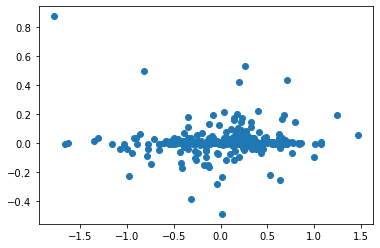

In [25]:
plt.scatter(x1, x2) 

ACH-000280    0.030451
ACH-000977    0.091667
ACH-000891   -0.133782
ACH-000066   -0.230280
ACH-000735    0.000000
                ...   
ACH-000631   -0.000453
ACH-000882   -0.075752
ACH-000911    0.005955
ACH-000022   -0.002169
ACH-000906   -0.001084
Length: 304, dtype: float64

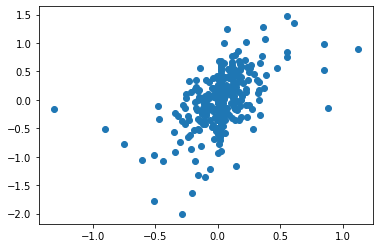

In [98]:
index_list = Y_pre_array.notna().index
plt.scatter(Y_pre_array[index_list], Y_total[index_list])

In [34]:
!pwd

/Users/jerryliu/jerry_jupyter/internship
